## Semantic Textual Similarity

Model Named on My HuggingFace Profile: 'sentence-t5-base-FT-Quora_Sentence_Similarity-LG'


Source for Dataset: https://www.kaggle.com/datasets/quora/question-pairs-dataset

### Exploratory Data Analysis (EDA)

#### Import Necessary Libraries

In [1]:
import os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from sentence_transformers import SentenceTransformer, models, util, losses, LoggingHandler, evaluation, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Versions of Libraries

In [2]:
print("Pandas:".ljust(10), pd.__version__)
print("Torch:".ljust(10), torch.__version__)

Pandas:    1.4.4
Torch:     1.12.1


#### Ingesting Data into Pandas DataFrame & Preprocessing Data

In [3]:
cols2use = ['qid1', 'qid2', 'question1', 'question2', 'is_duplicate']
col_types = {'qid1' : int, 'qid2' : int, 'question1' : str, 'question2' : str, 'is_duplicate' : int}

data = pd.read_csv('~/Documents/nlpnn/Datasets/Semantic_Similarity/questions.csv', usecols=cols2use, dtype=col_types)
data.rename(columns={'question1' : 'q1', 'question2' : 'q2', 'is_duplicate' : 'labels'}, inplace=True)

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404348 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   qid1    404348 non-null  int64 
 1   qid2    404348 non-null  int64 
 2   q1      404348 non-null  object
 3   q2      404348 non-null  object
 4   labels  404348 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


#### Visualization of Length of First Question (Sorted by Result)

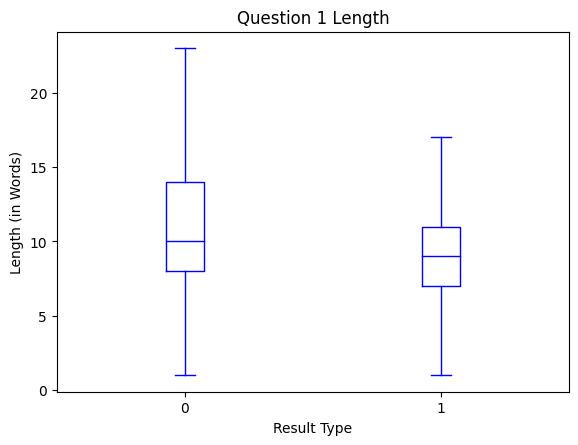

In [4]:
data['q1_len'] = data['q1'].str.split().apply(len)

data.boxplot("q1_len", by="labels", grid=False, showfliers=False, color="Blue")
plt.suptitle('')
plt.title('Question 1 Length')
plt.xlabel('Result Type')
plt.ylabel('Length (in Words)')
plt.show()

data.drop(columns=['q1_len'], inplace=True)

#### Visualization of Length of Second Question (Sorted by Result)

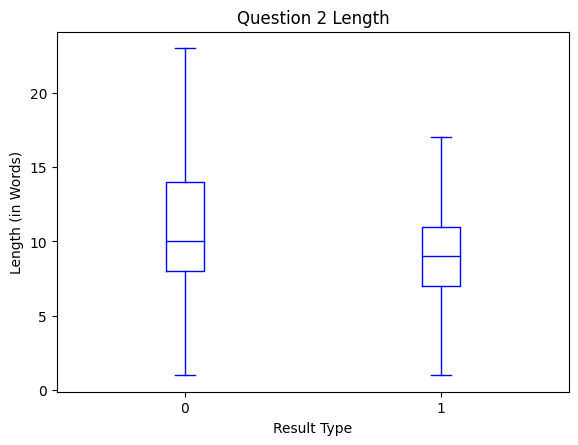

In [5]:
data['q2_len'] = data['q2'].str.split().apply(len)

data.boxplot("q2_len", by="labels", grid=False, showfliers=False, color="Blue")
plt.suptitle('')
plt.title('Question 2 Length')
plt.xlabel('Result Type')
plt.ylabel('Length (in Words)')
plt.show()

data.drop(columns=['q2_len'], inplace=True)

#### Limit Size of Dataset 

* Remove values that are too small or too large

In [6]:
data = data[data['q1'].str.split().apply(len) < 24]

data = data[data['q2'].str.split().apply(len) < 24]

print("Total samples:", data['labels'].shape[0])
print(data['labels'].value_counts())

Total samples: 373815
0    227614
1    146201
Name: labels, dtype: int64


### Start of the Actual Project

#### Train/Test/Valid Split

In [7]:
train_ds, testvalid = train_test_split(data, test_size=0.20, random_state=42)
test_ds, valid_ds = train_test_split(testvalid, test_size=0.50, random_state=42)

print(f"Training Data Shape: {train_ds.shape}")
print(f"Testing Data Shape: {test_ds.shape}")
print(f"Validation Data Shape: {valid_ds.shape}")

Training Data Shape: (299052, 5)
Testing Data Shape: (37381, 5)
Validation Data Shape: (37382, 5)


#### Instantiate Logging Function

In [8]:
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)

#### Encode Dataset & Instantiate the Model

In [9]:
model_ckpt = "sentence-transformers/sentence-t5-base"
device="cpu"

model = SentenceTransformer(model_ckpt, device=device)
model.max_seq_length = 34

embeddings = model.encode(['q1', 'q2'], show_progress_bar=True)

distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

margin = 0.50

num_of_epochs = 1

training_batch_size = 64
testing_batch_size = 16

model_save_path = f"{model_ckpt.split('/')[-1]}-FT-Quora_Sentence_Similarity-LG"

dataset_path = '/Users/briandunn/Documents/nlpnn/nlp_ch4/bin/sentence-t5-base-FT-Quora_Sentence_Similarity-LG/'
os.makedirs(model_save_path, exist_ok=True)

2022-09-17 12:46:07 - Load pretrained SentenceTransformer: sentence-transformers/sentence-t5-base


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


#### Assign Training Samples to DataLoader (InputExample)

In [10]:
train_samples = []

for index, row in train_ds.iterrows():
    sample = InputExample(texts=[row['q1'], row['q2']], label=int(row['labels']))
    train_samples.append(sample)

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=training_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

#### Set Up Validation Dataset

In [11]:
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []

for index, row in valid_ds.iterrows(): 
    dev_sentences1.append(row['q1'])
    dev_sentences2.append(row['q2'])
    dev_labels.append(row['labels'])

#### Create Function to Compute Metrics

In [12]:
binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, 
                                                                dev_sentences2, 
                                                                dev_labels, 
                                                                show_progress_bar=True, 
                                                                batch_size=testing_batch_size,
                                                                name="Quora_Sentence_Similarity_Metrics-LG",
                                                                write_csv=True)

#### Train Model

In [13]:
model.fit(train_objectives=[(train_dataloader, train_loss)],  
          evaluator = binary_acc_evaluator, 
          epochs=num_of_epochs, 
          warmup_steps=2,
          output_path=model_save_path, 
          show_progress_bar=True,
          checkpoint_path='checkpoints_LG/', 
          checkpoint_save_steps=5000,
          checkpoint_save_total_limit=10)

Epoch:   0%|          | 0/1 [56:17:12<?, ?it/s]

2022-09-19 21:03:46 - Binary Accuracy Evaluation of the model on Quora_Sentence_Similarity_Metrics-LG dataset after epoch 0:


Epoch:   0%|          | 0/1 [57:17:29<?, ?it/s]

2022-09-19 22:04:02 - Accuracy with Cosine-Similarity:           85.93	(Threshold: 0.8320)
2022-09-19 22:04:02 - F1 with Cosine-Similarity:                 82.89	(Threshold: 0.8178)
2022-09-19 22:04:02 - Precision with Cosine-Similarity:          77.43
2022-09-19 22:04:02 - Recall with Cosine-Similarity:             89.18
2022-09-19 22:04:02 - Average Precision with Cosine-Similarity:  87.13



Epoch:   0%|          | 0/1 [57:17:29<?, ?it/s]

2022-09-19 22:04:03 - Accuracy with Manhattan-Distance:           85.95	(Threshold: 12.7721)
2022-09-19 22:04:03 - F1 with Manhattan-Distance:                 82.89	(Threshold: 13.5008)
2022-09-19 22:04:03 - Precision with Manhattan-Distance:          76.91
2022-09-19 22:04:03 - Recall with Manhattan-Distance:             89.89
2022-09-19 22:04:03 - Average Precision with Manhattan-Distance:  87.13



Epoch:   0%|          | 0/1 [57:17:29<?, ?it/s]

2022-09-19 22:04:03 - Accuracy with Euclidean-Distance:           85.93	(Threshold: 0.5797)
2022-09-19 22:04:03 - F1 with Euclidean-Distance:                 82.89	(Threshold: 0.6037)
2022-09-19 22:04:03 - Precision with Euclidean-Distance:          77.43
2022-09-19 22:04:03 - Recall with Euclidean-Distance:             89.18
2022-09-19 22:04:03 - Average Precision with Euclidean-Distance:  87.13



Epoch:   0%|          | 0/1 [57:17:30<?, ?it/s]

2022-09-19 22:04:03 - Accuracy with Dot-Product:           85.93	(Threshold: 0.8320)
2022-09-19 22:04:03 - F1 with Dot-Product:                 82.89	(Threshold: 0.8178)
2022-09-19 22:04:03 - Precision with Dot-Product:          77.43
2022-09-19 22:04:03 - Recall with Dot-Product:             89.18
2022-09-19 22:04:03 - Average Precision with Dot-Product:  87.14

2022-09-19 22:04:03 - Save model to sentence-t5-base-FT-Quora_Sentence_Similarity-LG


Epoch: 100%|██████████| 1/1 [57:17:31<00:00, 206251.34s/it]


2022-09-19 22:04:04 - Save model to checkpoints_LG/4673


#### Saving Model to HuggingFace Hub (My Profile)

In [14]:
model.save_to_hub(repo_name=model_save_path, commit_message='All Dunn!')

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:38: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='sentence-t5-base-FT-Quora_Sentence_Similarity-LG' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  warnings.warn(
/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/huggingface_hub/hf_api.py:681: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


2022-09-19 22:04:07 - Create repository and clone it if it exists


Cloning https://huggingface.co/DunnBC22/sentence-t5-base-FT-Quora_Sentence_Similarity-LG into local empty directory.


2022-09-19 22:04:08 - Cloning https://huggingface.co/DunnBC22/sentence-t5-base-FT-Quora_Sentence_Similarity-LG into local empty directory.
2022-09-19 22:04:11 - Save model to /var/folders/vb/6w_1xfss7_zgtx5g93jlj0z80000gn/T/tmpu4y40r3g
2022-09-19 22:04:12 - Track files with git lfs: pytorch_model.bin
2022-09-19 22:04:12 - Push model to the hub. This might take a while


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 960k/418M [00:01<08:01, 909kB/s]
Upload file pytorch_model.bin:   1%|          | 2.69M/418M [00:03<07:54, 918kB/s]
Upload file pytorch_model.bin:   1%|          | 3.53M/418M [00:04<08:06, 895kB/s]
Upload file pytorch_model.bin:   6%|▌         | 24.8M/418M [00:22<05:02, 1.36MB/s]
Upload file pytorch_model.bin: 100%|█████████▉| 418M/418M [05:32<00:00, 1.42MB/s] remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/sentence-t5-base-FT-Quora_Sentence_Similarity-LG
   1fb0f90..6dcef6e  main -> main

                                                                                 

                                                                     
Upload file pytorch_model.bin: 100%|██████████| 418M/418M [05:34<00:00, 1.42MB/s]         


2022-09-19 22:09:55 - remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/sentence-t5-base-FT-Quora_Sentence_Similarity-LG
   1fb0f90..6dcef6e  main -> main



Upload file pytorch_model.bin: 100%|██████████| 418M/418M [05:35<00:00, 1.31MB/s]
Upload file 2_Dense/pytorch_model.bin: 100%|██████████| 2.25M/2.25M [05:35<00:00, 6.93kB/s]


Upload file spiece.model: 100%|██████████| 773k/773k [05:35<00:00, 2.26kB/s]


'https://huggingface.co/DunnBC22/sentence-t5-base-FT-Quora_Sentence_Similarity-LG/commit/6dcef6e0ef8a61b92030514c3dbce5b9f84fb9e3'